#### Embedding geometric descriptors

Geometric descriptors: largest included sphere (Di), largest free sphere (Df), largest included sphere along free path (Dif), crystal density (rho), volumetric surface area (VSA), gravimetric surface (GSA), volumetric pore volume (VPOV) and gravimetric pore volume (GPOV), cell volume

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import glob
import h5py
import random

#from keras.layers.merge import add
import matplotlib.pyplot as plt
import os
import scipy
import scipy.stats

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn, Tensor

In [4]:
core_df_train = pd.read_csv("CoRE2019_traindata.csv")
core_df_test = pd.read_csv("CoRE2019_testdata.csv")

In [5]:
train_ids = np.array(core_df_train['MOFname'].values)
test_ids = np.array(core_df_test['MOFname'].values)

availableIDs = np.array(list(train_ids) + list(test_ids))

In [6]:
concat_df = pd.concat([core_df_train, core_df_test], ignore_index=True)
concat_df = concat_df.loc[:, ~concat_df.columns.str.contains('^Unnamed')]

concat_df

,ASA [m^2/cm^3],CellV [A^3],Df,Di,Dif,NASA [m^2/cm^3],POAV [cm^3/g],POAVF,PONAV [cm^3/g],PONAVF,...,pure_methane_widomHOA,pure_uptake_CO2_298.00_15000,pure_uptake_CO2_298.00_1600000,pure_uptake_methane_298.00_580000,pure_uptake_methane_298.00_6500000,logKH_CO2,logKH_CH4,CH4DC,CH4HPSTP,CH4LPSTP
0,0.000,878.884,3.37000,4.71855,4.71855,516.355,0.000000,0.00000,0.205652,0.22676,...,-15.040840,2.651632,6.959545,1.517200,3.493840,-3.578895,-5.362861,60.807239,107.480722,46.673482
1,0.000,1320.380,2.49720,4.45543,4.40653,158.361,0.000000,0.00000,0.084751,0.12924,...,-28.088059,1.456535,1.659598,1.617679,1.645018,-3.069876,-3.908354,1.163132,69.986528,68.823397
2,1241.530,19186.400,4.32260,11.39486,11.33724,216.420,0.430017,0.40814,0.106519,0.10110,...,-18.634414,0.452906,8.814420,3.103085,8.424232,-4.353803,-4.770093,140.903866,223.073480,82.169614
3,1283.550,18921.000,4.51080,11.27344,11.27344,224.215,0.419845,0.41114,0.104997,0.10282,...,-18.644738,0.428606,8.653067,3.220068,8.341120,-4.388713,-4.755377,139.911701,227.886826,87.975125
4,0.000,2329.310,3.32948,4.93969,4.93889,209.511,0.000000,0.00000,0.090376,0.14018,...,-26.541762,1.261881,1.975084,1.804533,1.835901,-3.728093,-4.028960,1.357453,79.446960,78.089507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9520,0.000,13344.100,3.45844,4.78914,4.64139,222.948,0.000000,0.00000,0.118451,0.14048,...,-25.685788,2.326454,4.834563,3.277217,4.372734,-3.419877,-4.148596,36.248205,144.684000,108.435795
9521,2235.840,16868.900,7.60488,10.39835,10.39835,0.000,0.901793,0.67120,0.000000,0.00000,...,-13.399384,0.710561,18.711146,5.474003,14.514045,-4.323908,-4.808599,187.719473,301.388957,113.669484
9522,508.242,1723.820,3.79229,4.92972,4.92858,0.000,0.152321,0.25526,0.000000,0.00000,...,-17.508025,0.265892,2.549507,1.475888,2.242525,-4.712485,-5.262717,35.843109,104.846311,69.003202
9523,1079.710,2118.840,4.30750,5.55487,5.55487,0.000,0.247974,0.40118,0.000000,0.00000,...,-15.404376,0.563851,4.470632,2.107592,3.737340,-4.361533,-5.090285,73.560896,168.689962,95.129066


In [23]:
col_interest = [x for x in list(concat_df.columns[:16]) if x != 'MOFname']

In [65]:
X_train, y_train = core_df_train[col_interest].to_numpy(), core_df_train['pure_uptake_methane_298.00_6500000'].to_numpy()
X_test, y_test = core_df_test[col_interest].to_numpy(), core_df_test['pure_uptake_methane_298.00_6500000'].to_numpy()

print(f'Shape of train : {X_train.shape}')
print(f'Shape of test : {X_test.shape}')

Shape of train : (7525, 15)
Shape of test : (2000, 15)


In [102]:
class Geometric_Dataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [103]:
X_train, y_train, X_test, y_test = torch.tensor(X_train, dtype = torch.float), torch.tensor(y_train, dtype = torch.float), torch.tensor(X_test, dtype = torch.float), torch.tensor(y_test, dtype = torch.float)

train_dataset = Geometric_Dataset(X_train, y_train)
test_dataset = Geometric_Dataset(X_test, y_test)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

C:\Users\sarta\AppData\Local\Temp\ipykernel_6172\1709483805.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, y_train, X_test, y_test = torch.tensor(X_train, dtype = torch.float), torch.tensor(y_train, dtype = torch.float), torch.tensor(X_test, dtype = torch.float), torch.tensor(y_test, dtype = torch.float)


In [104]:
batch_size = 64
class TransformerGeo(nn.Module):
    """
    Returns embedding for geometric descriptors
    """
    def __init__(self, input_features=X_train.shape[1], seq_length=batch_size, transformer_heads=8, transformer_ff_dim=512, mlp_hidden_dim=256):
        super(TransformerGeo, self).__init__()
        self.input_proj = nn.Linear(input_features, seq_length)

        encoder_layer = nn.TransformerEncoderLayer(d_model=seq_length, nhead=transformer_heads, dim_feedforward=transformer_ff_dim)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.proj = nn.Sequential(
            nn.Linear(64, mlp_hidden_dim),
            nn.Softplus(),
            nn.Linear(mlp_hidden_dim, 512)
        )

    def forward(self, x):
        # Project input features to sequence length dimension
        x_proj = self.input_proj(x)
        x_proj = x_proj.transpose(0, 1)

        transformer_output = self.transformer_encoder(x_proj)
        transformer_output = transformer_output.transpose(0, 1)

        proj_out = self.proj(transformer_output)
        return proj_out

class GeoRegressor(nn.Module):
    def __init__(self, input_features=X_train.shape[1], seq_length=batch_size, transformer_heads=8, transformer_ff_dim=512, mlp_hidden_dim=256):
        super(GeoRegressor, self).__init__()
        
        self.transformer = TransformerGeo(input_features, seq_length, transformer_heads, transformer_ff_dim, mlp_hidden_dim)
        
        # MLP for regression output
        self.mlp = nn.Sequential(
            nn.Linear(512, mlp_hidden_dim),
            nn.ReLU(),
            nn.Linear(mlp_hidden_dim, 1)  # Output layer for regression
        )
        
    def forward(self, x):
        transformer_output = self.transformer(x)
        output = self.mlp(transformer_output)

        return output


In [115]:
model = GeoRegressor()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

c:\ProgramData\mambaforge\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [116]:
epochs = 70
loss_history, val_history, srcc_val_history = [], [], []

for epoch_counter in range(epochs):
    loss_temp = []
    for bn, (inputs, target) in enumerate(train_loader):
        target = target.reshape(-1, 1)
        outputs = model(inputs)
        loss = criterion(outputs, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_temp.append(loss.item())
    
    loss_history.append(np.mean(loss_temp))

    val_temp, srcc_temp = [], []
    model.eval()
    with torch.no_grad():
        for bn, (inputs, target) in enumerate(test_loader):
            target = target.reshape(-1, 1)
            outputs = model(inputs)
            loss_val = criterion(outputs, target)

            srcc_temp.append(scipy.stats.spearmanr(outputs.cpu().numpy(), target.cpu().numpy())[0])
            val_temp.append(loss_val.item())
        
        val_history.append(np.mean(val_temp))
        srcc_val_history.append(np.mean(srcc_temp))

    
    if epoch_counter % 10 == 0:
        print(f'Epoch : {epoch_counter}, Loss: {loss_history[-1]}, Val. Loss: {val_history[-1]}, SRCC_val: {srcc_val_history[-1]}')

Epoch : 0, Loss: 14.068593114869207, Val. Loss: 9.762876879784368, SRCC_val: 0.6981995155382251
Epoch : 10, Loss: 3.9848446866385956, Val. Loss: 4.680508236731252, SRCC_val: 0.8582210799952735
Epoch : 20, Loss: 2.856166314874959, Val. Loss: 3.4440757959119734, SRCC_val: 0.8871839182323052
Epoch : 30, Loss: 2.3726540482961216, Val. Loss: 2.8796601987654165, SRCC_val: 0.8991507148765211
Epoch : 40, Loss: 2.1705586039102993, Val. Loss: 2.923434488234981, SRCC_val: 0.9115295994328253
Epoch : 50, Loss: 2.0011502779447117, Val. Loss: 2.3558032551119403, SRCC_val: 0.913622533380598
Epoch : 60, Loss: 2.061977928520268, Val. Loss: 2.3491750186489475, SRCC_val: 0.9187891409665601


Text(0.5, 1.0, 'Learning curve')

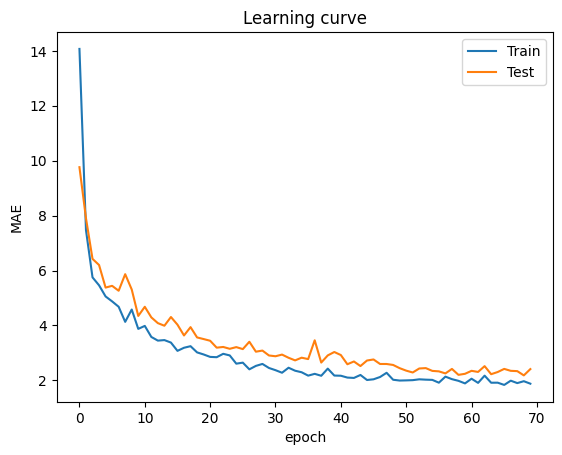

In [117]:
plt.plot(loss_history)
plt.plot(val_history)
plt.legend(['Train', 'Test'])
plt.xlabel('epoch')
plt.ylabel('MAE')
plt.title('Learning curve')

In [118]:
srcc_test = []
predict_test, actual_test = [], []
loss_test = []

model.eval()
with torch.no_grad():
    for bn, (inputs, target) in enumerate(test_loader):
        target = target.reshape(-1, 1)
        outputs = model(inputs)
        loss_test.append(nn.MSELoss()(outputs, target).item())
        srcc_test.append(scipy.stats.spearmanr(outputs.cpu().numpy(), target.cpu().numpy())[0])

        for i, j in zip(outputs.cpu().numpy(), target.cpu().numpy()):
            predict_test.append(i)
            actual_test.append(j)

print(f"SRCC_test : {np.mean(srcc_test)}")
print(f"MSE_test : {np.mean(loss_test)}")

SRCC_test : 0.9239985820630982
MSE_test : 2.412487018492914


In [119]:
srcc_train = []
predict_train, actual_train = [], []
loss_train = []

model.eval()
with torch.no_grad():
    for bn, (inputs, target) in enumerate(train_loader):
        target = target.reshape(-1, 1)
        outputs = model(inputs)
        loss_train.append(nn.MSELoss()(outputs, target).item())
        srcc_train.append(scipy.stats.spearmanr(outputs.cpu().numpy(), target.cpu().numpy())[0])

        for i, j in zip(outputs.cpu().numpy(), target.cpu().numpy()):
            predict_train.append(i)
            actual_train.append(j)

print(f"SRCC_train : {np.mean(srcc_train)}")
print(f"MSE_train : {np.mean(loss_train)}")

SRCC_train : 0.919853792930716
MSE_train : 1.9387820337572668


Text(0.5, 1.0, 'SRCC_test : 0.924, MSE_test: 2.412')

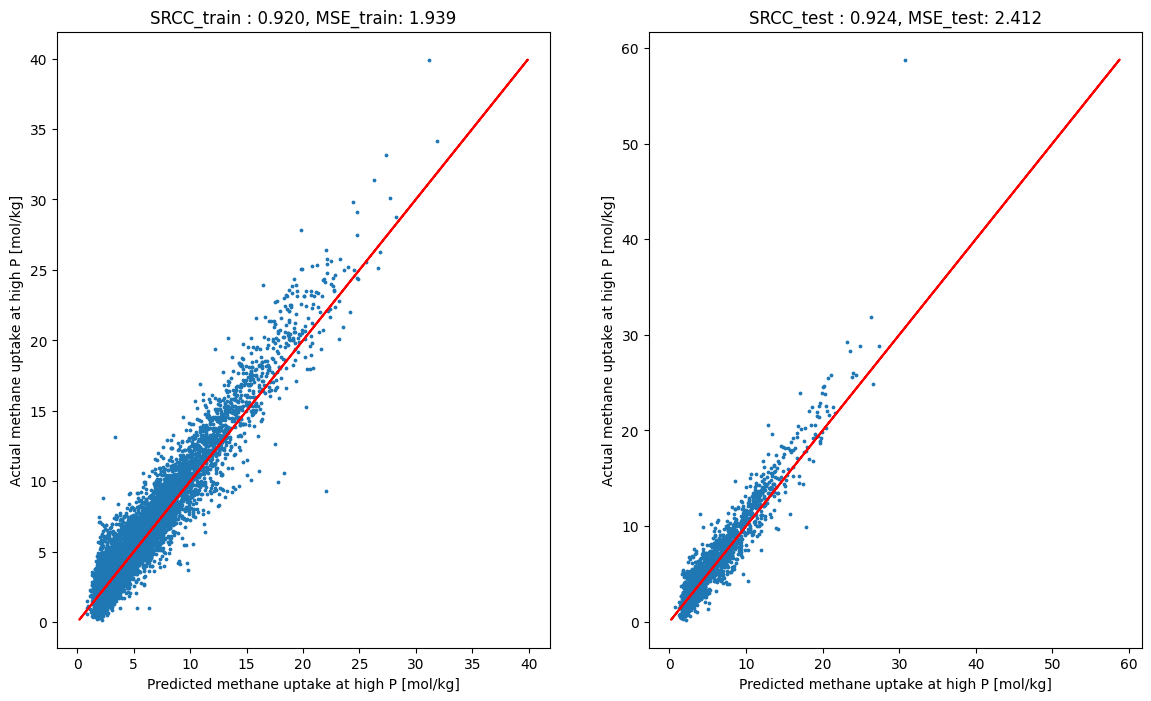

In [120]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 8))

ax1.scatter(predict_train, actual_train, s = 3)
ax1.plot(actual_train, actual_train, 'r-')
ax1.set_xlabel('Predicted methane uptake at high P [mol/kg]')
ax1.set_ylabel('Actual methane uptake at high P [mol/kg]')
ax1.set_title('SRCC_train : {:.3f}, MSE_train: {:.3f}'.format(np.mean(srcc_train), np.mean(loss_train)))

ax2.scatter(predict_test, actual_test, s = 3)
ax2.plot(actual_test, actual_test, 'r-')
ax2.set_xlabel('Predicted methane uptake at high P [mol/kg]')
ax2.set_ylabel('Actual methane uptake at high P [mol/kg]')
ax2.set_title('SRCC_test : {:.3f}, MSE_test: {:.3f}'.format(np.mean(srcc_test), np.mean(loss_test)))
